In [1]:
# ============================================================
# INSTALL DEPENDENCIES
# ============================================================
!pip install -q qiskit qiskit-aer matplotlib pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.1 MB/s eta 0:00:00


In [3]:
# ============================================================
# IMPORTS + PLOT RENDERING FIX
# ============================================================
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# Force stable inline backend and sane defaults
%matplotlib inline
import matplotlib
matplotlib.use("module://matplotlib_inline.backend_inline")
plt.rcParams["figure.dpi"] = 120

# ============================================================
# CORE: QPE + Inverse QFT
# ============================================================
def inverse_qft(qc, n):
    """Apply the inverse Quantum Fourier Transform on n qubits (in-place)."""
    # swap to reverse order
    for qubit in range(n // 2):
        qc.swap(qubit, n - qubit - 1)
    # controlled phases + H
    for j in range(n):
        for k in range(j):
            qc.cp(-np.pi / 2 ** (j - k), k, j)
        qc.h(j)
    return qc

def qpe_circuit(num_count_qubits, theta):
    """
    QPE circuit for U|1> = e^{2πiθ}|1>.
    theta ∈ [0,1).
    """
    qc = QuantumCircuit(num_count_qubits + 1, num_count_qubits)
    # 1) Hadamard on counting qubits
    qc.h(range(num_count_qubits))
    # 2) Prepare eigenstate |1> on target
    qc.x(num_count_qubits)
    # 3) Controlled-U^2^k (here U = phase rotation by 2πθ)
    for k in range(num_count_qubits):
        qc.cp(2 * np.pi * theta * (2 ** k), k, num_count_qubits)
    # 4) Inverse QFT on counting register
    inverse_qft(qc, num_count_qubits)
    # 5) Measure counting qubits
    qc.measure(range(num_count_qubits), range(num_count_qubits))
    return qc

def decimal_to_binary_fraction(decimal, num_bits):
    """Convert decimal phase to binary fraction string with num_bits precision."""
    binary_str, value = "", decimal
    for _ in range(num_bits):
        value *= 2
        if value >= 1:
            binary_str += "1"
            value -= 1
        else:
            binary_str += "0"
    return binary_str


In [4]:

# ============================================================
# TASK 1: Change the Phase Value
# ============================================================
def task1_different_phases():
    """Try different theta values: 0.125, 0.25, 0.375, 0.5 with subplots + display(fig)."""
    print("=" * 60)
    print("TASK 1: Testing Different Phase Values")
    print("=" * 60)

    simulator = AerSimulator()
    num_count_qubits = 3
    theta_values = [0.125, 0.25, 0.375, 0.5]

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for idx, theta in enumerate(theta_values):
        qc = qpe_circuit(num_count_qubits, theta)
        compiled_circuit = transpile(qc, simulator)
        result = simulator.run(compiled_circuit, shots=2048).result()
        counts = result.get_counts()

        # Plot on the given axis and still capture the parent fig
        plot_histogram(counts, ax=axes[idx], title=f'θ = {theta}')

        # Stats
        most = max(counts, key=counts.get)
        measured_decimal = int(most, 2) / (2 ** num_count_qubits)
        print(f"\nθ = {theta}:")
        print(f"  Most frequent measurement: {most}")
        print(f"  Estimated phase: {measured_decimal}")
        print(f"  Error: {abs(theta - measured_decimal)}")

    fig.tight_layout()
    display(fig)                      # <<—— force render
    fig.savefig('task1_phase_comparison.png', dpi=150, bbox_inches='tight')
    plt.close(fig)

    # Circuit diagram — mpl
    print("\nCircuit Diagram (Text):")
    qc_example = qpe_circuit(num_count_qubits, 0.125)
    print(qc_example.draw(output='text'))
    try:
        fig2 = qc_example.draw(output='mpl', style='iqp', fold=20)
        display(fig2)
        fig2.savefig('task1_circuit.png', dpi=150, bbox_inches='tight')
        plt.close(fig2)
    except Exception as e:
        print("MPL draw skipped:", e)


In [5]:

# ============================================================
# TASK 2: Increase Number of Counting Qubits
# ============================================================
def task2_more_qubits():
    """Use 3, 4, 5 counting qubits for higher precision."""
    print("\n" + "=" * 60)
    print("TASK 2: Higher Precision with More Qubits")
    print("=" * 60)

    simulator = AerSimulator()
    theta = 0.125
    qubit_counts = [3, 4, 5]

    fig, axes = plt.subplots(1, 3, figsize=(16, 4))

    for idx, num_qubits in enumerate(qubit_counts):
        qc = qpe_circuit(num_qubits, theta)
        compiled_circuit = transpile(qc, simulator)
        result = simulator.run(compiled_circuit, shots=2048).result()
        counts = result.get_counts()

        plot_histogram(counts, ax=axes[idx], title=f'{num_qubits} Counting Qubits')

        most = max(counts, key=counts.get)
        measured_decimal = int(most, 2) / (2 ** num_qubits)

        print(f"\n{num_qubits} counting qubits:")
        print(f"  Measurement: {most}")
        print(f"  Estimated phase: {measured_decimal}")
        print(f"  Error: {abs(theta - measured_decimal)}")
        print(f"  Precision: ±{1/(2**num_qubits)}")

    fig.tight_layout()
    display(fig)
    fig.savefig('task2_precision_comparison.png', dpi=150, bbox_inches='tight')
    plt.close(fig)

    print("\nCircuit Diagrams (Text):")
    for num_qubits in qubit_counts:
        qc = qpe_circuit(num_qubits, theta)
        print(f"\n{num_qubits} qubits:")
        print(qc.draw(output='text', fold=-1))

    # MPL circuits as a single figure with subplots
    try:
        fig2, axes2 = plt.subplots(3, 1, figsize=(14, 12))
        for idx, num_qubits in enumerate(qubit_counts):
            ret = qpe_circuit(num_qubits, theta).draw(output='mpl', style='iqp', ax=axes2[idx], fold=20)
            axes2[idx].set_title(f'{num_qubits} Counting Qubits')
        fig2.tight_layout()
        display(fig2)
        fig2.savefig('task2_circuits.png', dpi=150, bbox_inches='tight')
        plt.close(fig2)
    except Exception as e:
        print("MPL multi-circuit draw skipped:", e)


In [6]:

# ============================================================
# TASK 3: Compare with Theoretical Output
# ============================================================
def task3_theoretical_comparison():
    """Calculate expected binary representation and compare."""
    print("\n" + "=" * 60)
    print("TASK 3: Theoretical vs Experimental Comparison")
    print("=" * 60)

    simulator = AerSimulator()
    test_cases = [
        (3, 0.125),  # 1/8 = 0.001
        (3, 0.25),   # 1/4 = 0.010
        (4, 0.375),  # 3/8 = 0.0110 (approx with 4 bits)
        (4, 0.5625), # 9/16 = 0.1001
    ]

    for num_qubits, theta in test_cases:
        qc = qpe_circuit(num_qubits, theta)
        compiled_circuit = transpile(qc, simulator)
        result = simulator.run(compiled_circuit, shots=2048).result()
        counts = result.get_counts()

        theoretical_binary = decimal_to_binary_fraction(theta, num_qubits)
        most = max(counts, key=counts.get)
        measured_decimal = int(most, 2) / (2 ** num_qubits)

        print(f"\nθ = {theta} ({num_qubits} qubits):")
        print(f"  Theoretical binary: 0.{theoretical_binary}")
        print(f"  Expected measurement: {theoretical_binary}")
        print(f"  Actual measurement: {most}")
        print(f"  Match: {'✓' if most == theoretical_binary else '✗'}")
        print(f"  Measured phase: {measured_decimal}")
        print(f"  Probability: {counts[most]/2048*100:.1f}%")

    print("\nCircuit Diagrams (Text):")
    for num_qubits, theta in test_cases:
        qc = qpe_circuit(num_qubits, theta)
        print(f"\nθ = {theta}, {num_qubits} qubits:")
        print(qc.draw(output='text', fold=-1))

    # MPL circuits grid
    try:
        fig, axes = plt.subplots(2, 2, figsize=(14, 12))
        axes = axes.flatten()
        for idx, (num_qubits, theta) in enumerate(test_cases):
            ret = qpe_circuit(num_qubits, theta).draw(output='mpl', style='iqp', ax=axes[idx], fold=20)
            axes[idx].set_title(f'θ={theta}, {num_qubits} qubits')
        fig.tight_layout()
        display(fig)
        fig.savefig('task3_circuits.png', dpi=150, bbox_inches='tight')
        plt.close(fig)
    except Exception as e:
        print("MPL grid draw skipped:", e)


In [7]:

# ============================================================
# TASK 4: Inverse QFT Visualization
# ============================================================
def task4_visualize_iqft():
    """Visualize the circuit structure including inverse QFT."""
    print("\n" + "=" * 60)
    print("TASK 4: Inverse QFT Circuit Visualization")
    print("=" * 60)

    num_count_qubits = 3
    theta = 0.125

    # Build circuit WITHOUT final measurement, to visualize structure
    qc_visual = QuantumCircuit(num_count_qubits + 1)
    qc_visual.h(range(num_count_qubits))
    qc_visual.x(num_count_qubits)
    for qubit in range(num_count_qubits):
        qc_visual.cp(2 * np.pi * theta * (2 ** qubit), qubit, num_count_qubits)
    qc_visual.barrier()
    inverse_qft(qc_visual, num_count_qubits)

    print("\nCircuit Diagram (Text):")
    print(qc_visual.draw(output='text'))

    try:
        fig = qc_visual.draw(output='mpl', style='iqp', fold=-1)
        display(fig)
        fig.savefig('task4_circuit_diagram.png', dpi=150, bbox_inches='tight')
        plt.close(fig)
        print("\nCircuit diagram saved as 'task4_circuit_diagram.png'")
    except Exception as e:
        print("\nMPL visualization skipped:", e)

# ============================================================
# TASK 5: Noise Simulation
# ============================================================
def task5_noise_simulation():
    """Introduce noise model and observe accuracy impact."""
    print("\n" + "=" * 60)
    print("TASK 5: Noise Simulation Impact")
    print("=" * 60)

    theta = 0.125
    num_count_qubits = 4
    noise_levels = [0.0, 0.01, 0.05, 0.1]  # depolarizing probabilities

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for idx, error_prob in enumerate(noise_levels):
        if error_prob == 0.0:
            simulator = AerSimulator()
            label = "No Noise"
        else:
            noise_model = NoiseModel()
            err1 = depolarizing_error(error_prob, 1)
            err2 = depolarizing_error(error_prob, 2)
            noise_model.add_all_qubit_quantum_error(err1, ['h', 'x'])
            noise_model.add_all_qubit_quantum_error(err2, ['cp', 'swap'])
            simulator = AerSimulator(noise_model=noise_model)
            label = f"Error = {error_prob}"

        qc = qpe_circuit(num_count_qubits, theta)
        compiled_circuit = transpile(qc, simulator)
        result = simulator.run(compiled_circuit, shots=2048).result()
        counts = result.get_counts()

        plot_histogram(counts, ax=axes[idx], title=label)

        most = max(counts, key=counts.get)
        measured_decimal = int(most, 2) / (2 ** num_count_qubits)
        theoretical = decimal_to_binary_fraction(theta, num_count_qubits)
        fidelity = counts.get(theoretical, 0) / 2048 * 100

        print(f"\n{label}:")
        print(f"  Most frequent: {most} ({counts[most]} counts)")
        print(f"  Estimated phase: {measured_decimal}")
        print(f"  Error: {abs(theta - measured_decimal)}")
        print(f"  Fidelity (P(correct)): {fidelity:.1f}%")

    fig.tight_layout()
    display(fig)
    fig.savefig('task5_noise_comparison.png', dpi=150, bbox_inches='tight')
    plt.close(fig)

    print("\nCircuit Diagram (Text):")
    qc = qpe_circuit(num_count_qubits, theta)
    print(qc.draw(output='text', fold=-1))



Quantum Phase Estimation - Student Tasks

TASK 1: Testing Different Phase Values

θ = 0.125:
  Most frequent measurement: 001
  Estimated phase: 0.125
  Error: 0.0

θ = 0.25:
  Most frequent measurement: 010
  Estimated phase: 0.25
  Error: 0.0

θ = 0.375:
  Most frequent measurement: 011
  Estimated phase: 0.375
  Error: 0.0

θ = 0.5:
  Most frequent measurement: 100
  Estimated phase: 0.5
  Error: 0.0


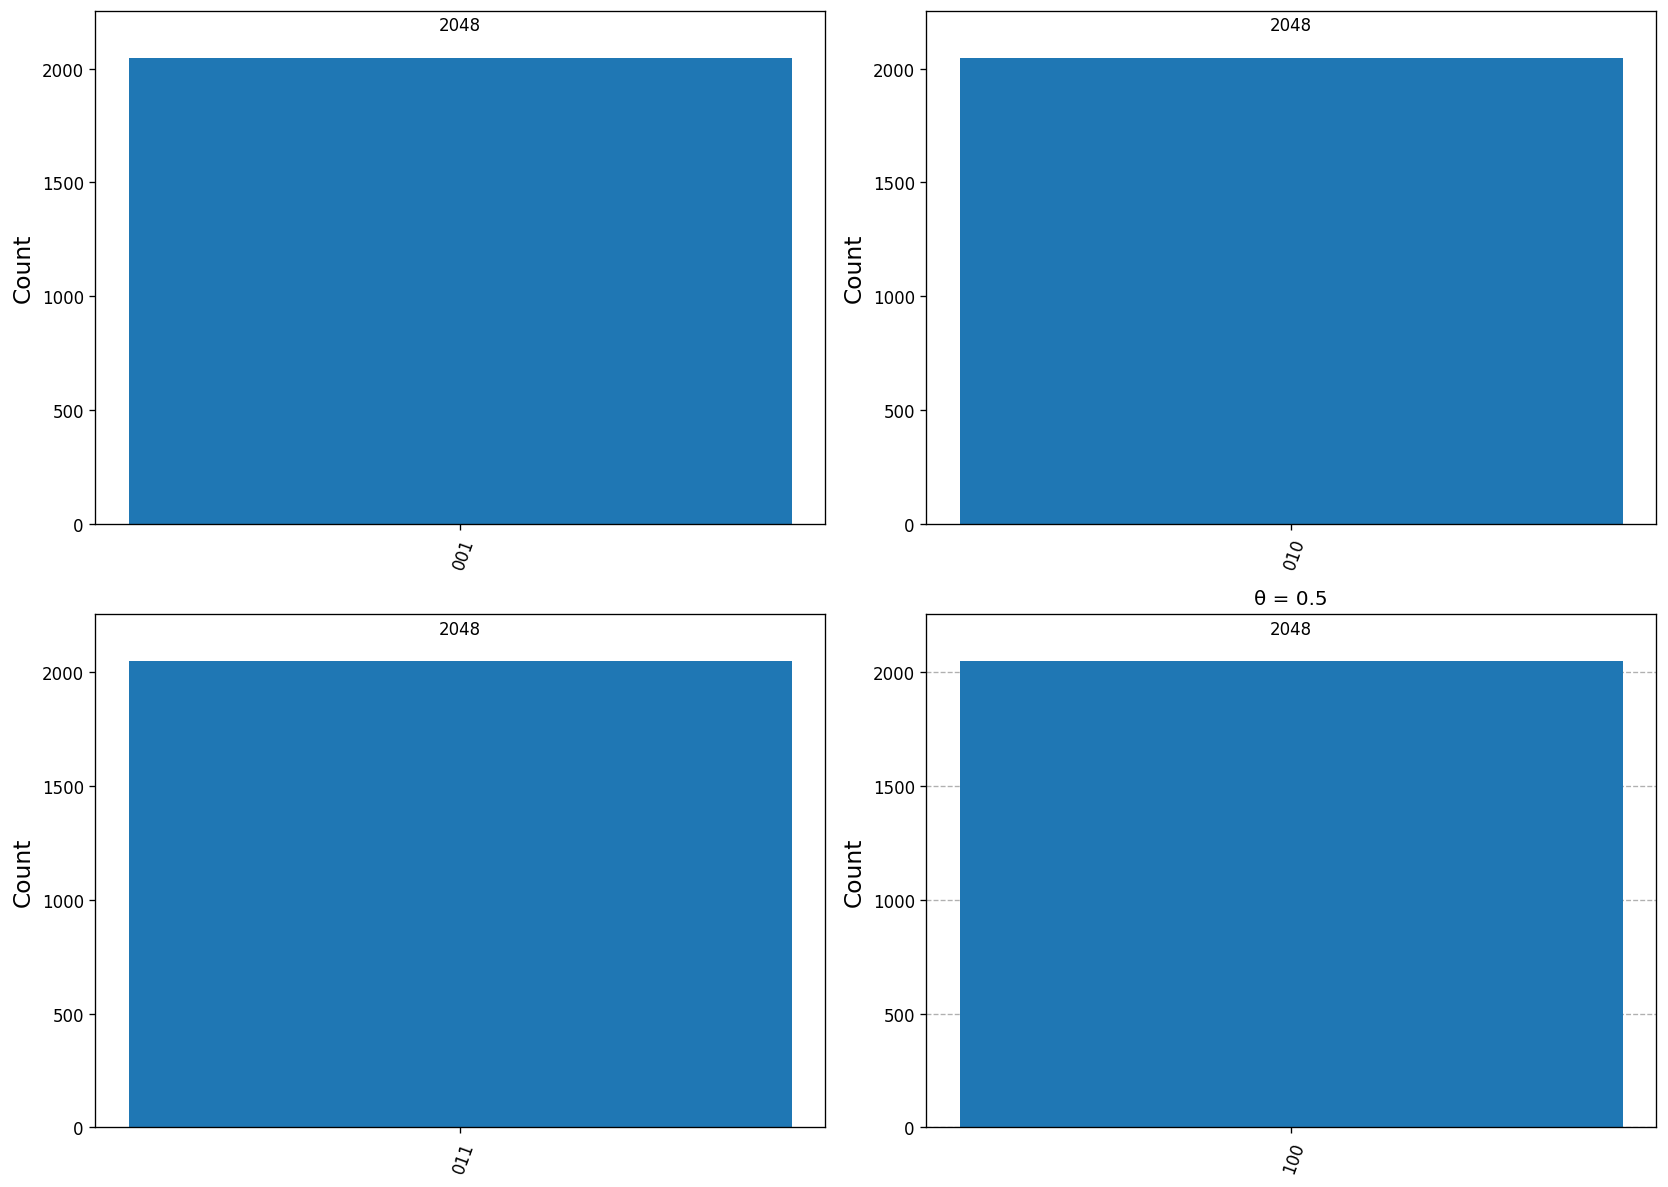


Circuit Diagram (Text):
     ┌───┐                            ┌───┐                                   »
q_0: ┤ H ├─■────────────────────────X─┤ H ├─■──────────────■──────────────────»
     ├───┤ │                        │ └───┘ │P(-π/2) ┌───┐ │                  »
q_1: ┤ H ├─┼────────■───────────────┼───────■────────┤ H ├─┼─────────■────────»
     ├───┤ │        │               │                └───┘ │P(-π/4)  │P(-π/2) »
q_2: ┤ H ├─┼────────┼────────■──────X──────────────────────■─────────■────────»
     ├───┤ │P(π/4)  │P(π/2)  │P(π)                                            »
q_3: ┤ X ├─■────────■────────■────────────────────────────────────────────────»
     └───┘                                                                    »
c: 3/═════════════════════════════════════════════════════════════════════════»
                                                                              »
«     ┌─┐           
«q_0: ┤M├───────────
«     └╥┘     ┌─┐   
«q_1: ─╫──────┤M├───
«      ║ ┌─

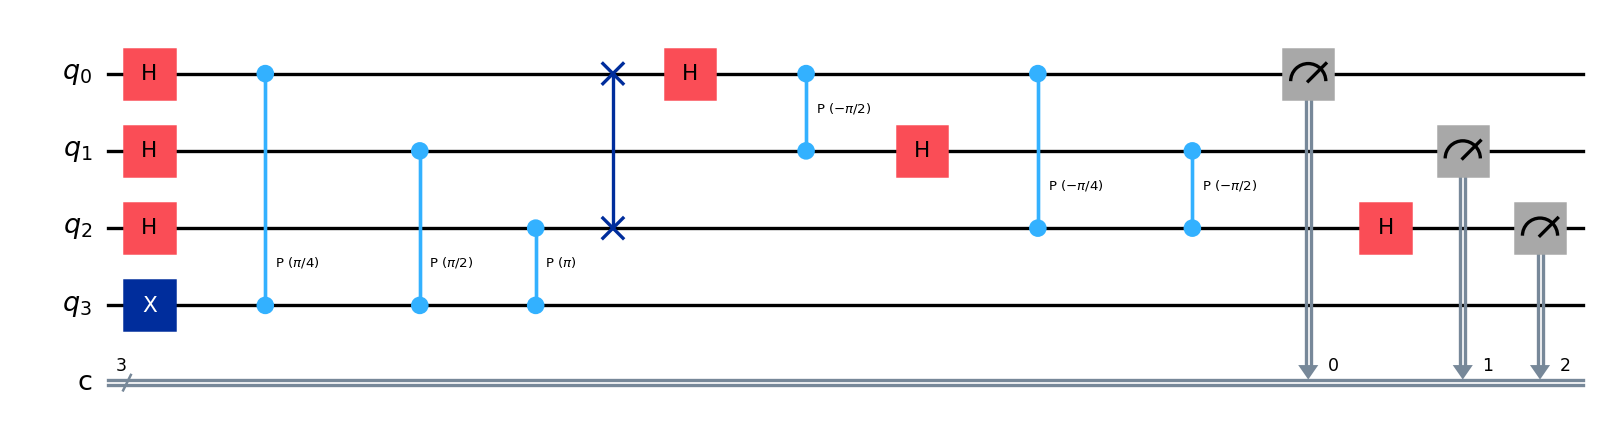


TASK 2: Higher Precision with More Qubits

3 counting qubits:
  Measurement: 001
  Estimated phase: 0.125
  Error: 0.0
  Precision: ±0.125

4 counting qubits:
  Measurement: 0010
  Estimated phase: 0.125
  Error: 0.0
  Precision: ±0.0625

5 counting qubits:
  Measurement: 00100
  Estimated phase: 0.125
  Error: 0.0
  Precision: ±0.03125


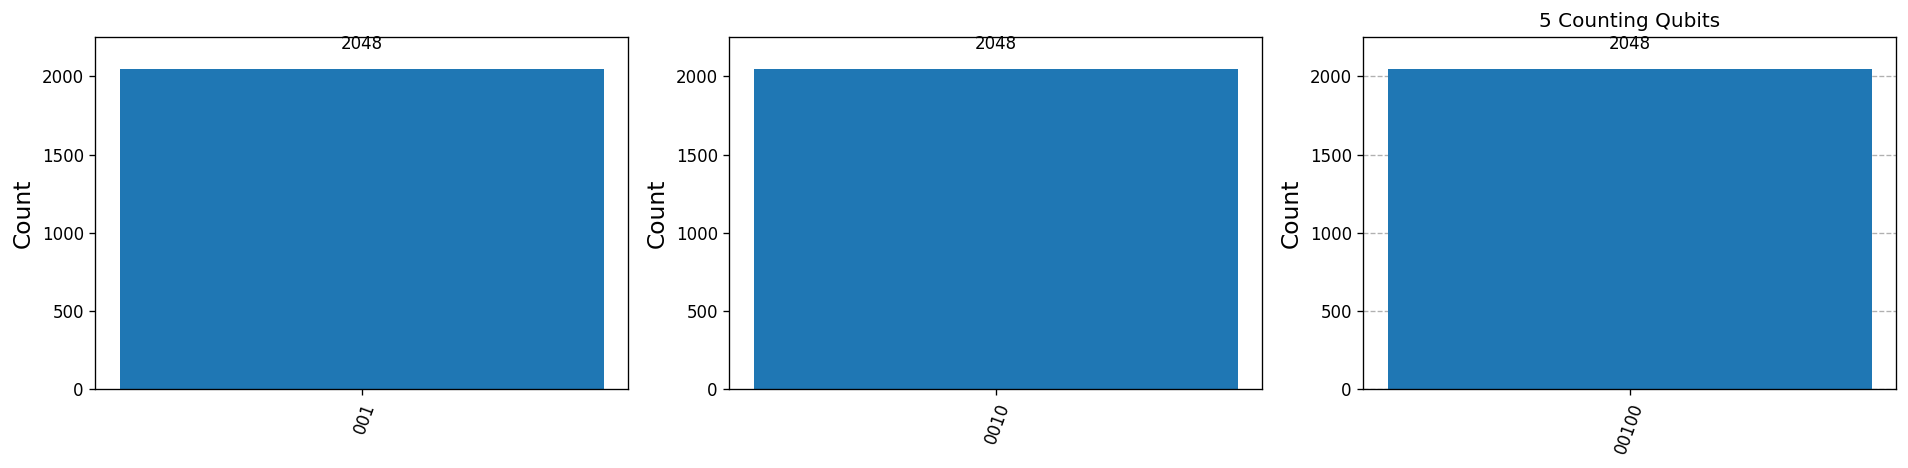


Circuit Diagrams (Text):

3 qubits:
     ┌───┐                            ┌───┐                                   ┌─┐           
q_0: ┤ H ├─■────────────────────────X─┤ H ├─■──────────────■──────────────────┤M├───────────
     ├───┤ │                        │ └───┘ │P(-π/2) ┌───┐ │                  └╥┘     ┌─┐   
q_1: ┤ H ├─┼────────■───────────────┼───────■────────┤ H ├─┼─────────■─────────╫──────┤M├───
     ├───┤ │        │               │                └───┘ │P(-π/4)  │P(-π/2)  ║ ┌───┐└╥┘┌─┐
q_2: ┤ H ├─┼────────┼────────■──────X──────────────────────■─────────■─────────╫─┤ H ├─╫─┤M├
     ├───┤ │P(π/4)  │P(π/2)  │P(π)                                             ║ └───┘ ║ └╥┘
q_3: ┤ X ├─■────────■────────■─────────────────────────────────────────────────╫───────╫──╫─
     └───┘                                                                     ║       ║  ║ 
c: 3/══════════════════════════════════════════════════════════════════════════╩═══════╩══╩═
                                 

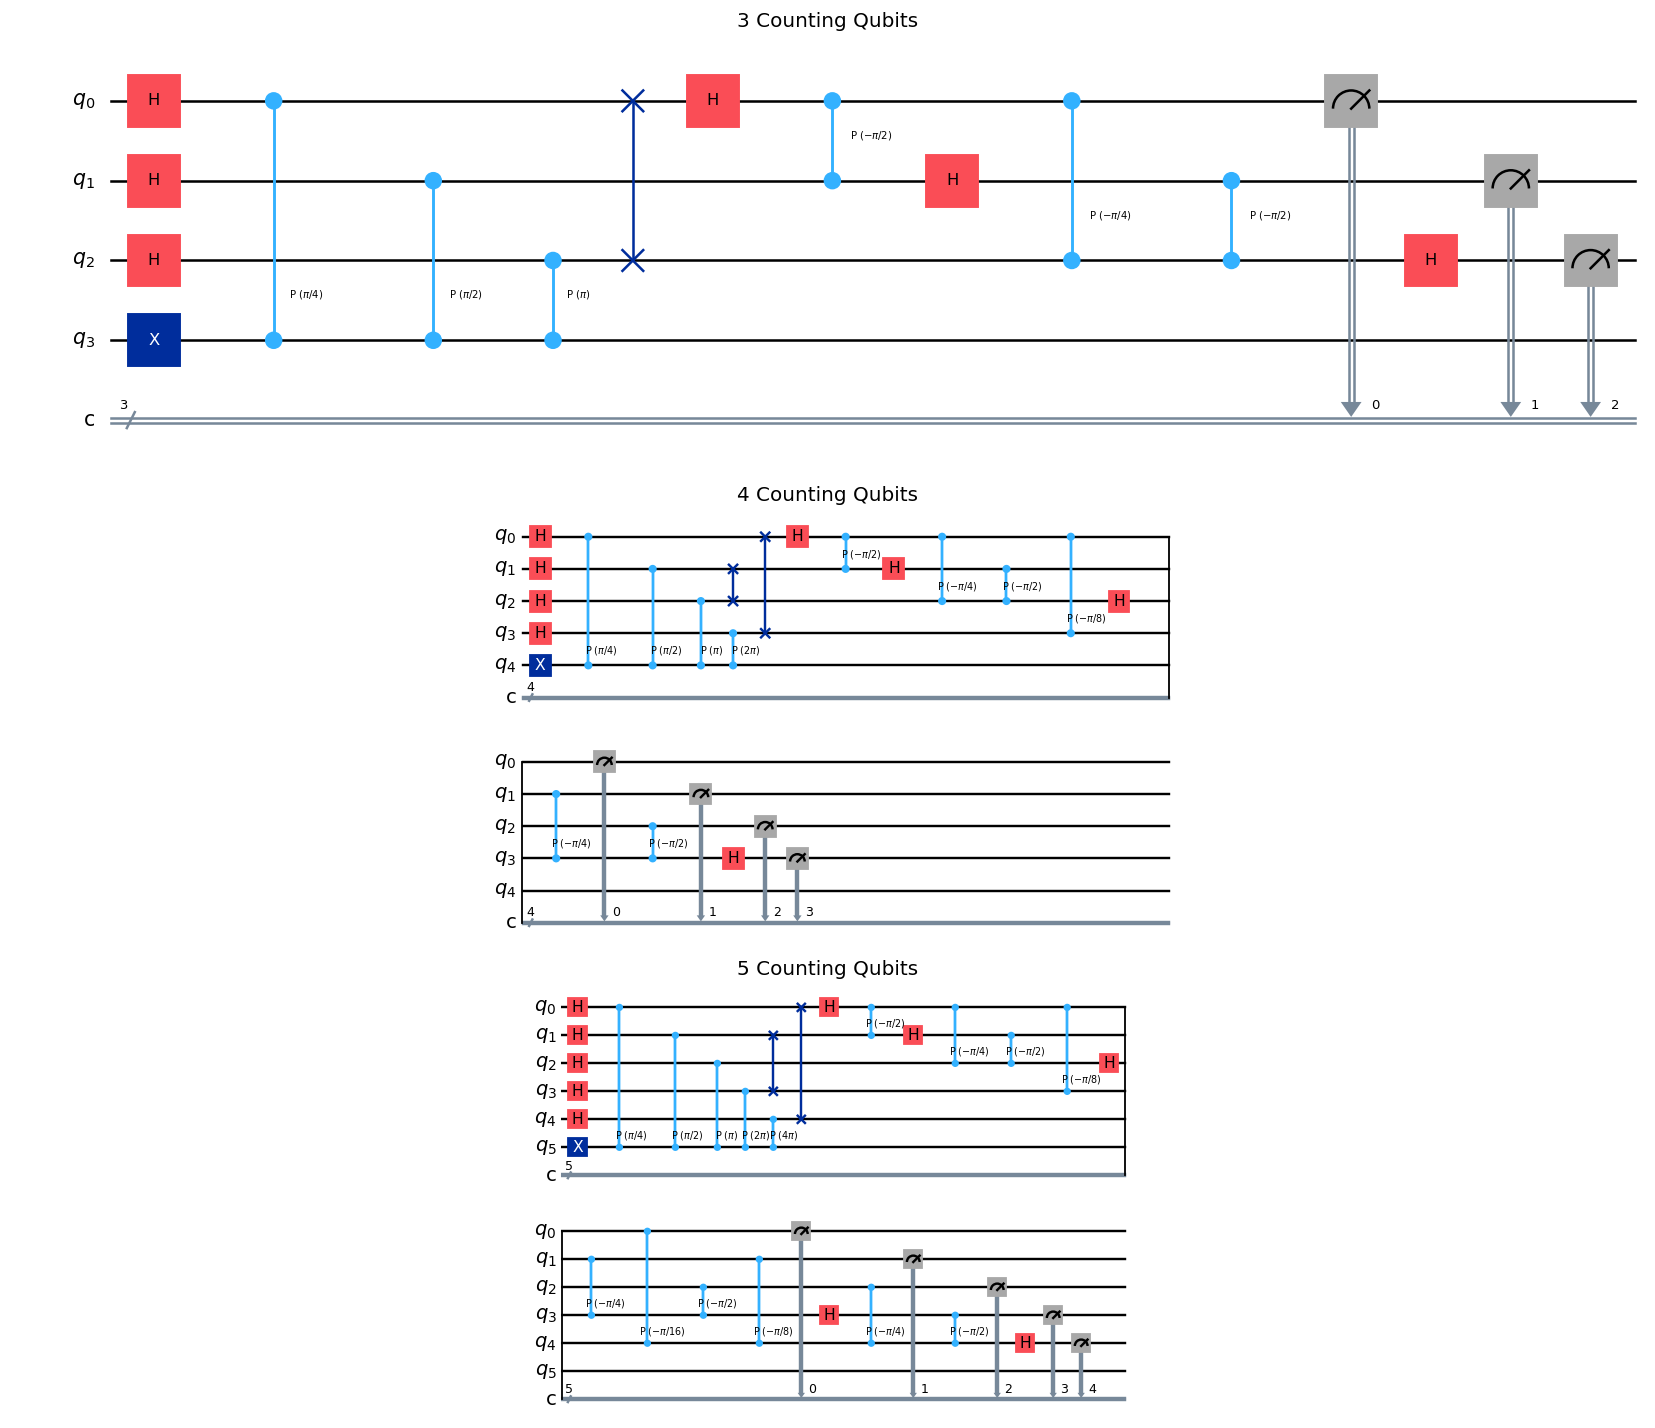


TASK 3: Theoretical vs Experimental Comparison

θ = 0.125 (3 qubits):
  Theoretical binary: 0.001
  Expected measurement: 001
  Actual measurement: 001
  Match: ✓
  Measured phase: 0.125
  Probability: 100.0%

θ = 0.25 (3 qubits):
  Theoretical binary: 0.010
  Expected measurement: 010
  Actual measurement: 010
  Match: ✓
  Measured phase: 0.25
  Probability: 100.0%

θ = 0.375 (4 qubits):
  Theoretical binary: 0.0110
  Expected measurement: 0110
  Actual measurement: 0110
  Match: ✓
  Measured phase: 0.375
  Probability: 100.0%

θ = 0.5625 (4 qubits):
  Theoretical binary: 0.1001
  Expected measurement: 1001
  Actual measurement: 1001
  Match: ✓
  Measured phase: 0.5625
  Probability: 100.0%

Circuit Diagrams (Text):

θ = 0.125, 3 qubits:
     ┌───┐                            ┌───┐                                   ┌─┐           
q_0: ┤ H ├─■────────────────────────X─┤ H ├─■──────────────■──────────────────┤M├───────────
     ├───┤ │                        │ └───┘ │P(-π/2) ┌───┐ │    

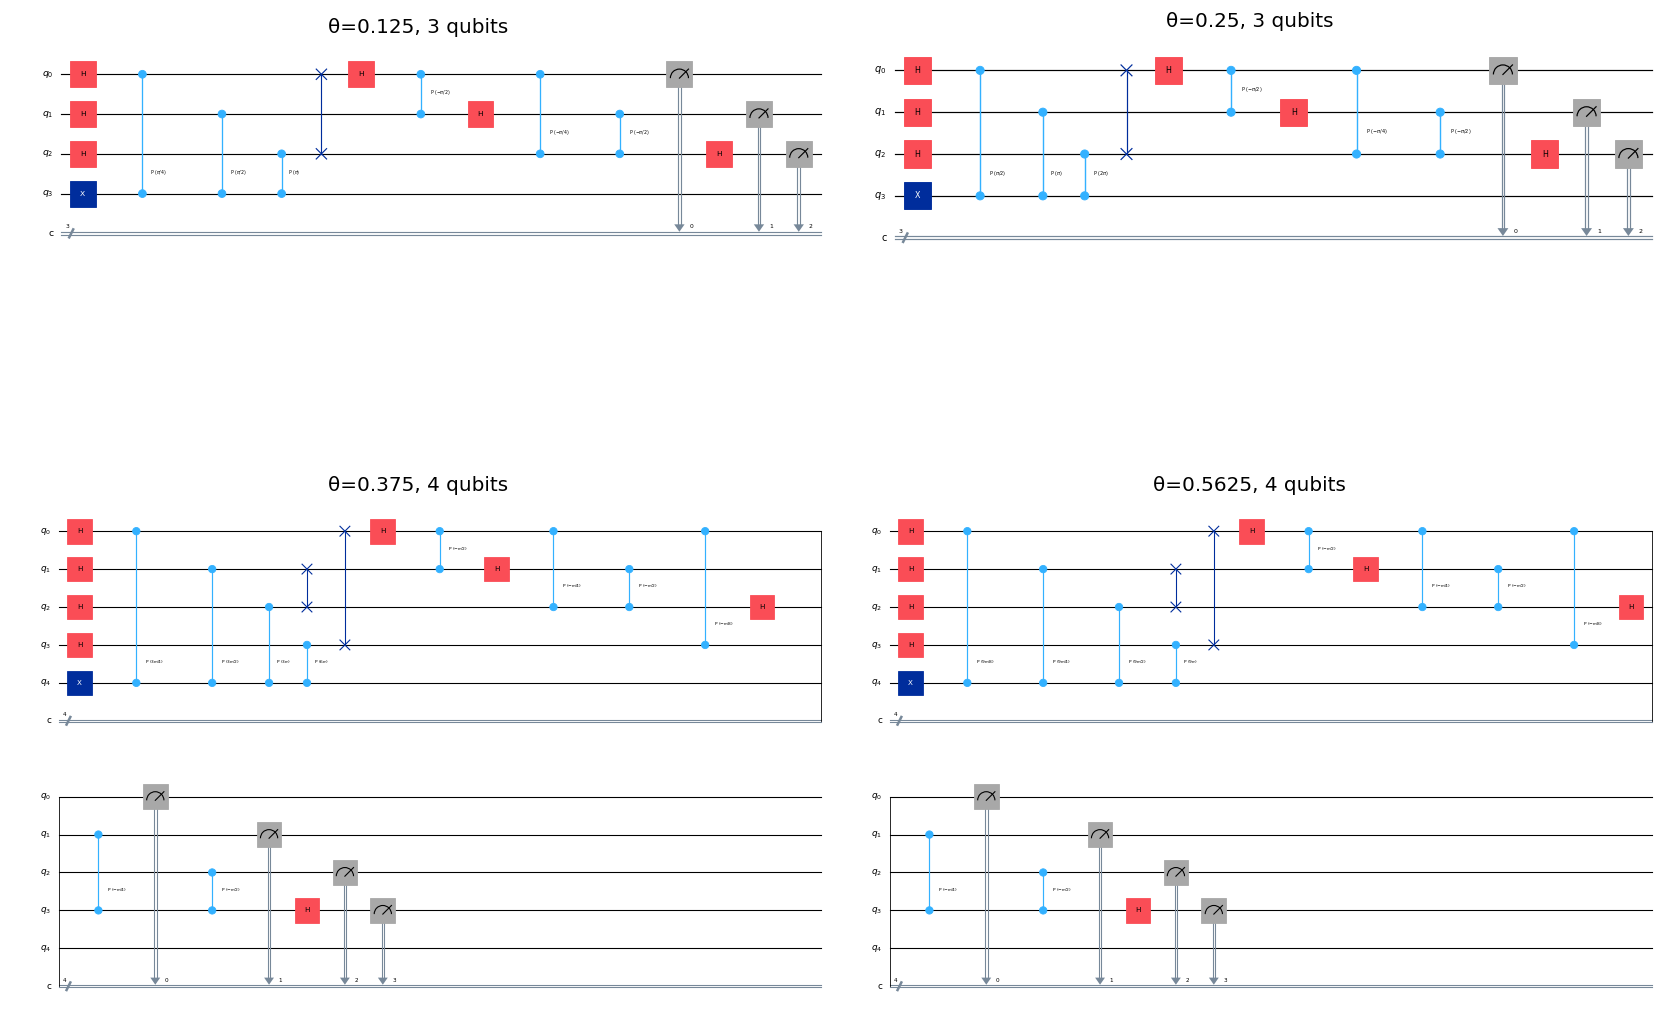


TASK 4: Inverse QFT Circuit Visualization

Circuit Diagram (Text):
     ┌───┐                          ░    ┌───┐                         »
q_0: ┤ H ├─■────────────────────────░──X─┤ H ├─■──────────────■────────»
     ├───┤ │                        ░  │ └───┘ │P(-π/2) ┌───┐ │        »
q_1: ┤ H ├─┼────────■───────────────░──┼───────■────────┤ H ├─┼────────»
     ├───┤ │        │               ░  │                └───┘ │P(-π/4) »
q_2: ┤ H ├─┼────────┼────────■──────░──X──────────────────────■────────»
     ├───┤ │P(π/4)  │P(π/2)  │P(π)  ░                                  »
q_3: ┤ X ├─■────────■────────■──────░──────────────────────────────────»
     └───┘                          ░                                  »
«                    
«q_0: ───────────────
«                    
«q_1: ─■─────────────
«      │P(-π/2) ┌───┐
«q_2: ─■────────┤ H ├
«               └───┘
«q_3: ───────────────
«                    


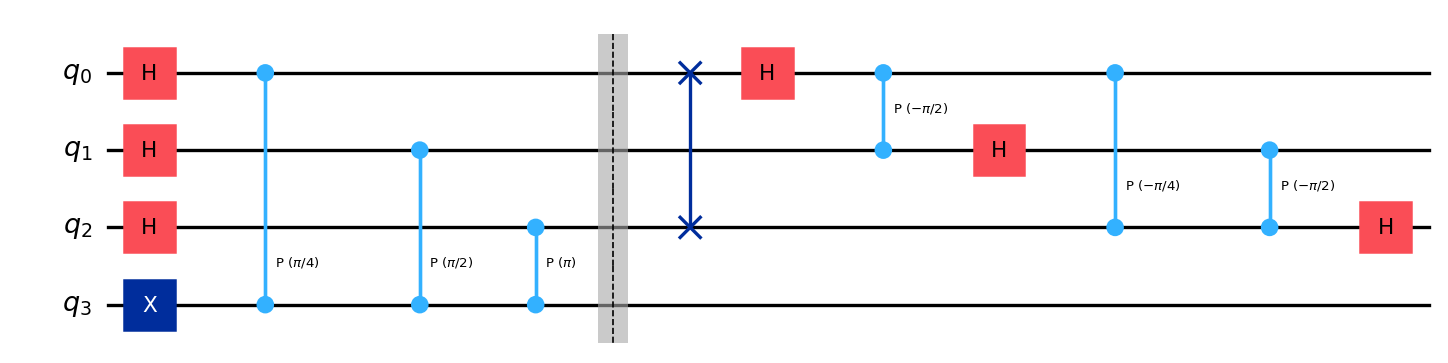


Circuit diagram saved as 'task4_circuit_diagram.png'

TASK 5: Noise Simulation Impact

No Noise:
  Most frequent: 0010 (2048 counts)
  Estimated phase: 0.125
  Error: 0.0
  Fidelity (P(correct)): 100.0%

Error = 0.01:
  Most frequent: 0010 (1864 counts)
  Estimated phase: 0.125
  Error: 0.0
  Fidelity (P(correct)): 91.0%

Error = 0.05:
  Most frequent: 0010 (1266 counts)
  Estimated phase: 0.125
  Error: 0.0
  Fidelity (P(correct)): 61.8%

Error = 0.1:
  Most frequent: 0010 (781 counts)
  Estimated phase: 0.125
  Error: 0.0
  Fidelity (P(correct)): 38.1%


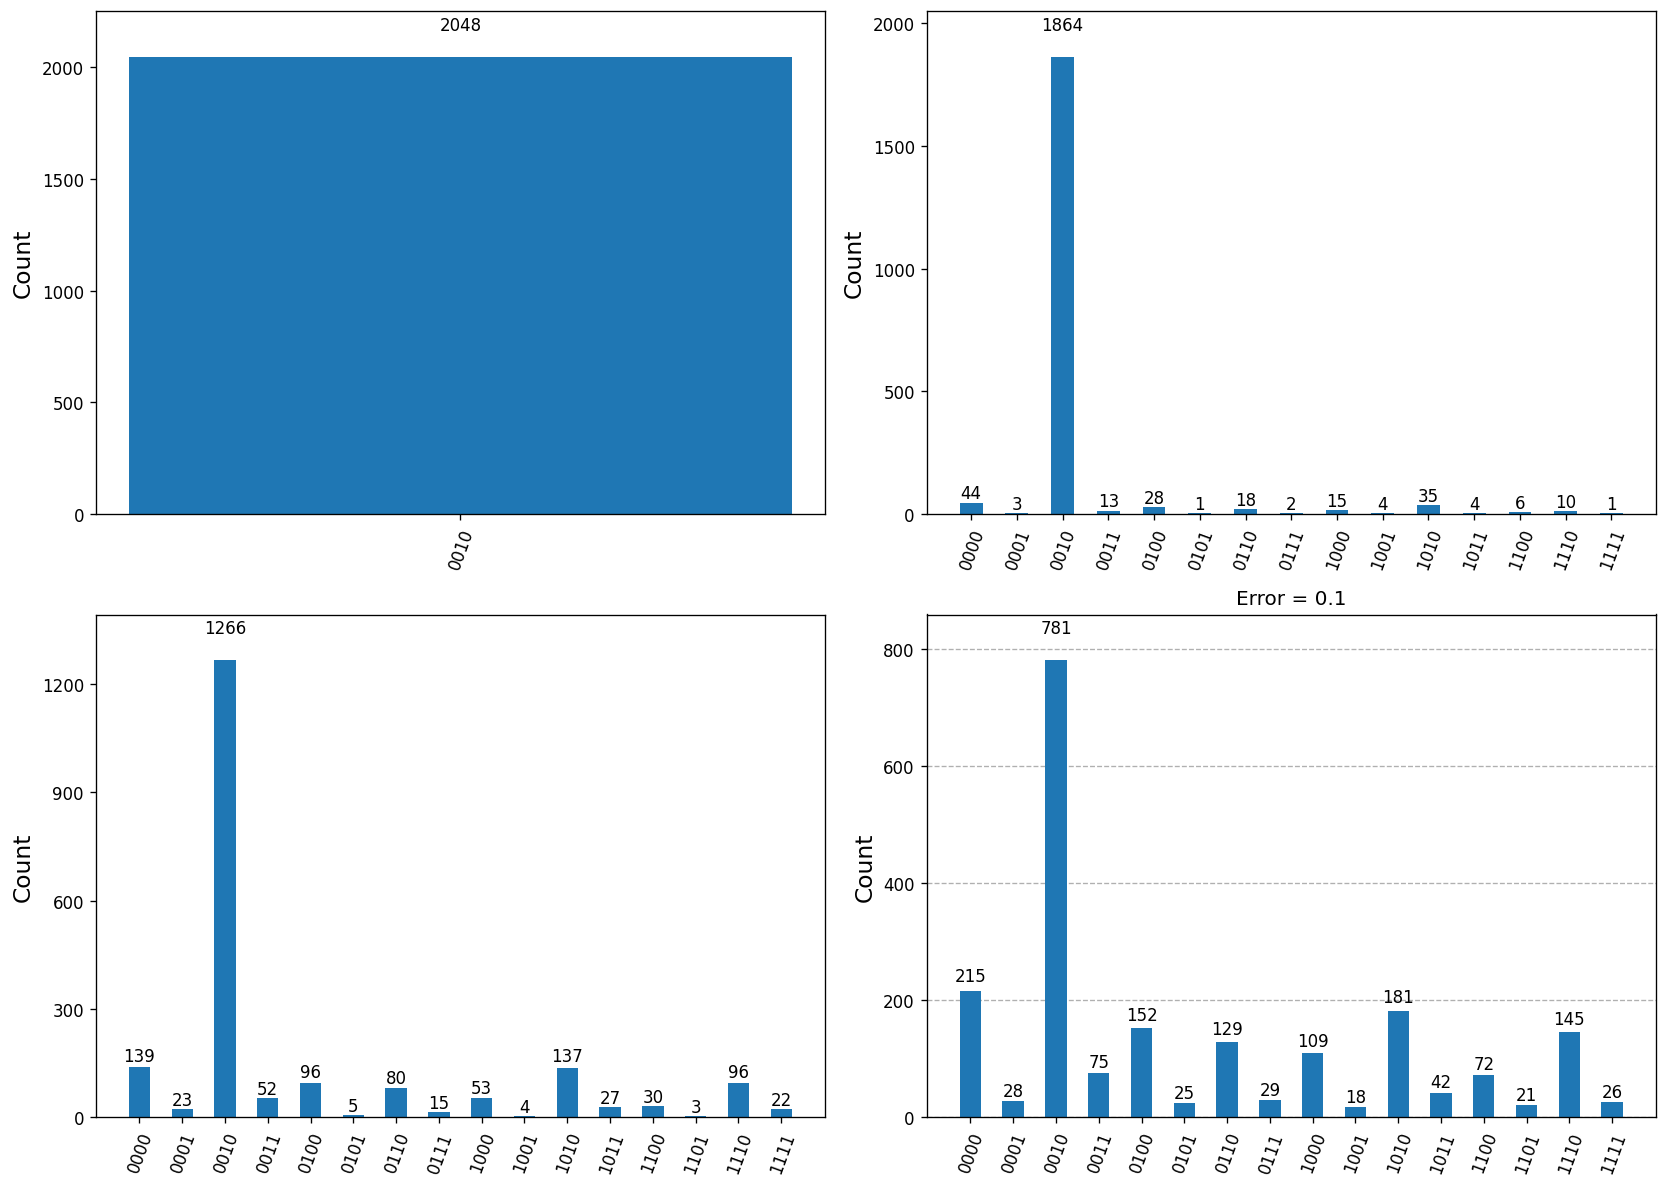


Circuit Diagram (Text):
     ┌───┐                                    ┌───┐                                                            ┌─┐                        
q_0: ┤ H ├─■────────────────────────────────X─┤ H ├─■──────────────■───────────────────■───────────────────────┤M├────────────────────────
     ├───┤ │                                │ └───┘ │P(-π/2) ┌───┐ │                   │                       └╥┘          ┌─┐           
q_1: ┤ H ├─┼────────■─────────────────X─────┼───────■────────┤ H ├─┼─────────■─────────┼──────────────■─────────╫───────────┤M├───────────
     ├───┤ │        │                 │     │                └───┘ │P(-π/4)  │P(-π/2)  │        ┌───┐ │         ║           └╥┘     ┌─┐   
q_2: ┤ H ├─┼────────┼────────■────────X─────┼──────────────────────■─────────■─────────┼────────┤ H ├─┼─────────╫──■─────────╫──────┤M├───
     ├───┤ │        │        │              │                                          │P(-π/8) └───┘ │P(-π/4)  ║  │P(-π/2)  ║ ┌───┐└╥┘┌─┐
q_

In [8]:
# ============================================================
# MAIN EXECUTION
# ============================================================
if __name__ == "__main__":
    print("Quantum Phase Estimation - Student Tasks\n")

    task1_different_phases()
    task2_more_qubits()
    task3_theoretical_comparison()
    task4_visualize_iqft()
    task5_noise_simulation()

    print("\n" + "=" * 60)
    print("All tasks completed!")
    print("=" * 60)
